# Analysis of electroencephalograms

## The usual imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2, pickle, os.path
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from statsmodels.tools import categorical
from sklearn.ensemble import RandomForestRegressor
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sampling_rate = 160 # From physionet database
plt.style.use('seaborn')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### MNE library for reading EDF files

In [ ]:
!pip install mne
import mne

     |████████████████████████████████| 6.9MB 7.9MB/s 


# Getting data

In [ ]:
!wget -c 'https://www.physionet.org/static/published-projects/eegmmidb/eeg-motor-movementimagery-dataset-1.0.0.zip'

--2020-10-10 04:10:39--  https://www.physionet.org/static/published-projects/eegmmidb/eeg-motor-movementimagery-dataset-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997435063 (1.9G) [application/zip]
Saving to: ‘eeg-motor-movementimagery-dataset-1.0.0.zip’

eeg-motor-movementi 100%[===================>]   1.86G  2.16MB/s    in 50m 31s 

2020-10-10 05:01:10 (644 KB/s) - ‘eeg-motor-movementimagery-dataset-1.0.0.zip’ saved [1997435063/1997435063]



## Type of movements

### Resting, eyes open

Filenames ending in '01' are resting, eyes open. Annotations give the timing of events, T0 - rest, T1 - onset of movement in left fist (in runs 3), T2 - movement in right fist (in runs 3)

In [ ]:
file='files/S001/S001R01.edf'
data = mne.io.read_raw_edf(file)
xreo = data.get_data()
annotations = mne.read_annotations(file)
annotations.onset

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


array([0.])

### Resting eyes closed

Filenames ending in '02' are resting, eyes closed

In [ ]:
file='files/S001/S001R02.edf'
data = mne.io.read_raw_edf(file)
xreo = data.get_data()

an = mne.read_annotations(file)
an.onset

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


array([0.])

### Fist (real)

Filnames ending in 03 contain real fist movements, T1 - left fist, T2 - right fist

In [ ]:
file='files/S001/S001R03.edf'
data = mne.io.read_raw_edf(file)
xfist = data.get_data()
an = mne.read_annotations(file)
print(an.onset)
print(an.duration)
print(an.description)

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[  0.    4.2   8.3  12.5  16.6  20.8  24.9  29.1  33.2  37.4  41.5  45.7
  49.8  54.   58.1  62.3  66.4  70.6  74.7  78.9  83.   87.2  91.3  95.5
  99.6 103.8 107.9 112.1 116.2 120.4]
[4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1
 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1]
['T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1'
 'T0' 'T2' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2'
 'T0' 'T1']


#### Finding the interval where the left fist was opened (first time)

And converting it to array samples by multiplying with sampling rate

In [ ]:
for i in range(len(an.onset)):
  if an.description[i] == 'T1':
    start_sec = an.onset[i]
    if an.description[i+1] == 'T0':
      end_sec = an.onset[i+1]
      break
start_sec, end_sec

(12.5, 16.6)

In [ ]:
xfist[:,int(start_sec*sampling_rate):int(end_sec*sampling_rate)].shape

(64, 656)

## Fist (imagined)

Filenames ending in '04' have imagined movements

In [ ]:
%ls

data_eo_ec.npy  data_fist.npy  files/  labels_eo_ec.npy  labels_fist.npy


In [ ]:
filename='files/S001/S001R04.edf'
data = mne.io.read_raw_edf(filename)
xfist = data.get_data()
an = mne.read_annotations(file)
print(an.onset)
print(an.duration)
print(an.description)

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
[  0.    4.2   8.3  12.5  16.6  20.8  24.9  29.1  33.2  37.4  41.5  45.7
  49.8  54.   58.1  62.3  66.4  70.6  74.7  78.9  83.   87.2  91.3  95.5
  99.6 103.8 107.9 112.1 116.2 120.4]
[4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1
 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1]
['T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1'
 'T0' 'T2' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2'
 'T0' 'T1']


## Plot a single patient

### Resting, eyes open

In [ ]:
file='files/S001/S001R01.edf'
data = mne.io.read_raw_edf(file)
xreo = data.get_data()

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Figure size 432x288 with 0 Axes>

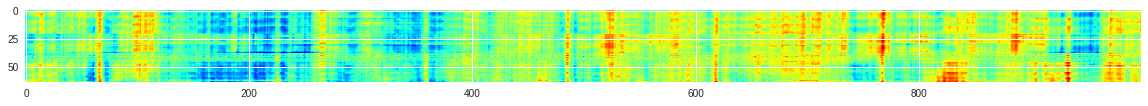

In [ ]:
plt.jet()
plt.figure(figsize=(20,10))
plt.imshow(xreo[:,0:1000])

(-0.0005, 0.0005)

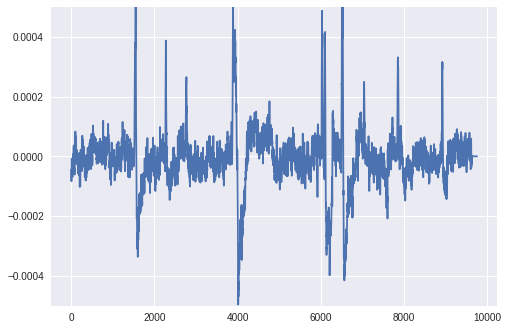

In [ ]:
plt.plot(xreo[22]) # Lead 23, frontal
plt.ylim(-0.0005,0.0005)

In [ ]:
file='files/S001/S001R02.edf'
data = mne.io.read_raw_edf(file)
xrec = data.get_data()

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(-0.0005, 0.0005)

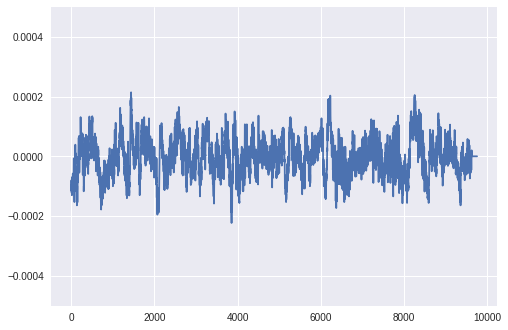

In [ ]:
plt.plot(xrec[22]) # Lead 23, frontal
plt.ylim(-0.0005,0.0005)

(-0.0005, 0.0005)

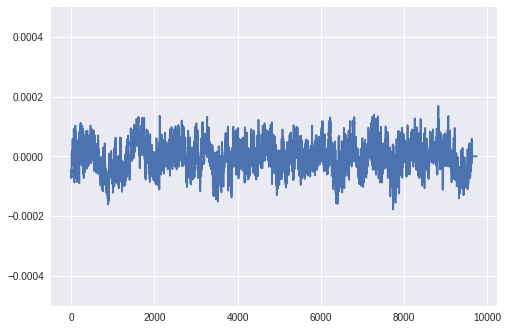

In [ ]:
plt.plot(xrec[38]) # Lead 40, right fronto temporal
plt.ylim(-0.0005,0.0005)

(-0.0005, 0.0005)

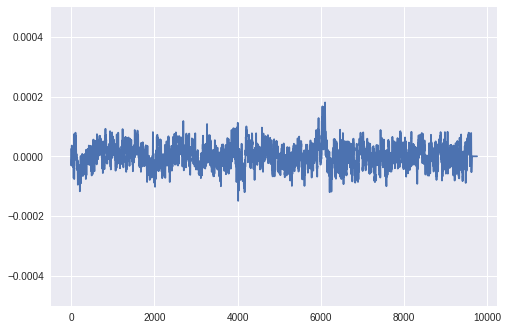

In [ ]:
plt.plot(xreo[54]) # Lead 43, left temporal
plt.ylim(-0.0005,0.0005)

In [ ]:
file='files/S001/S001R07.edf'
data = mne.io.read_raw_edf(file)
xlfist = data.get_data()

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Text(0.5, 1.0, 'Right pareital')

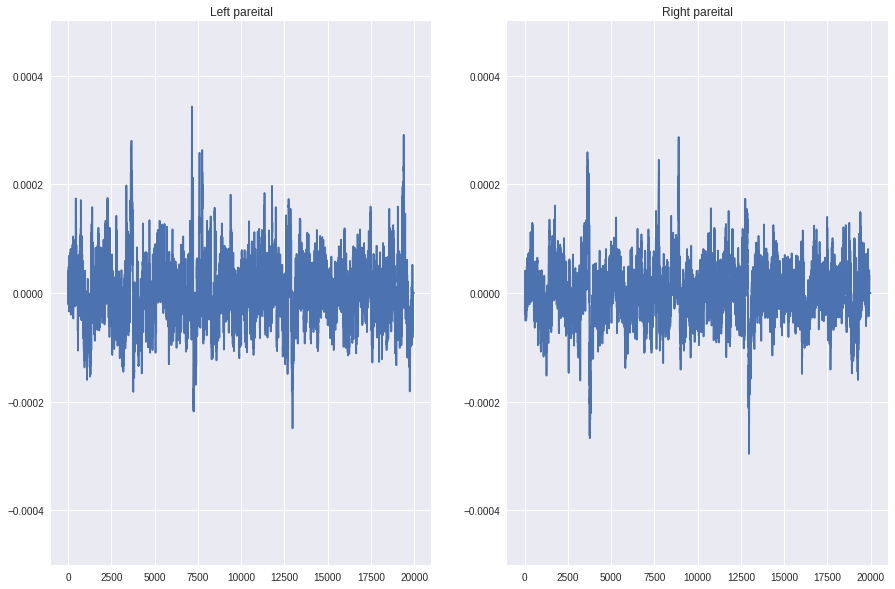

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(xlfist[0])
plt.ylim(-0.0005,0.0005)
plt.title('Left pareital')
plt.subplot(122)
plt.plot(xlfist[6])
plt.ylim(-0.0005,0.0005)
plt.title('Right pareital')

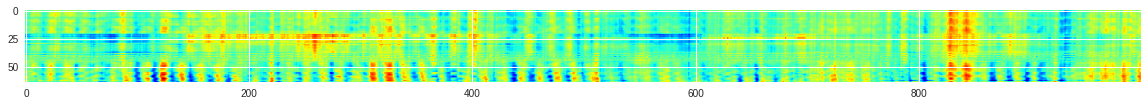

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(xrec[:,8000:9000])

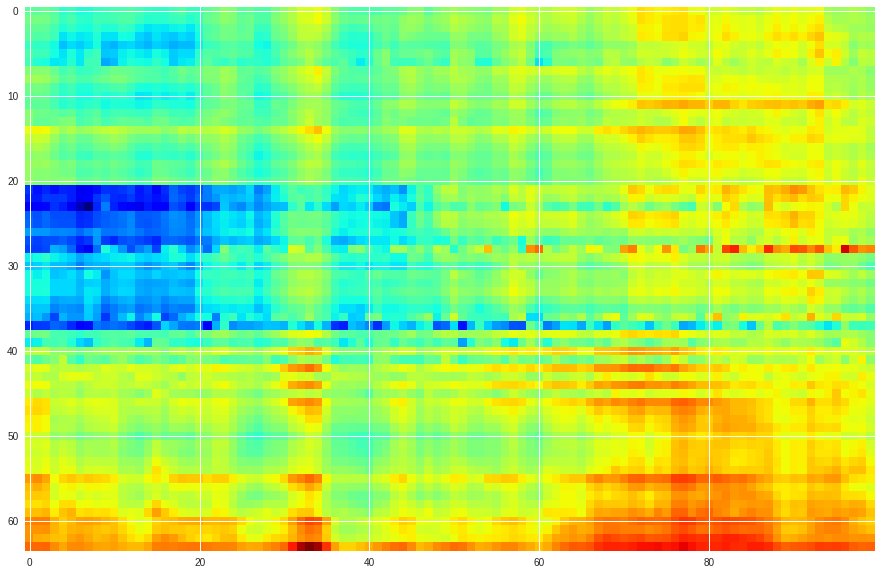

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(xlfist[:,13000:13100])

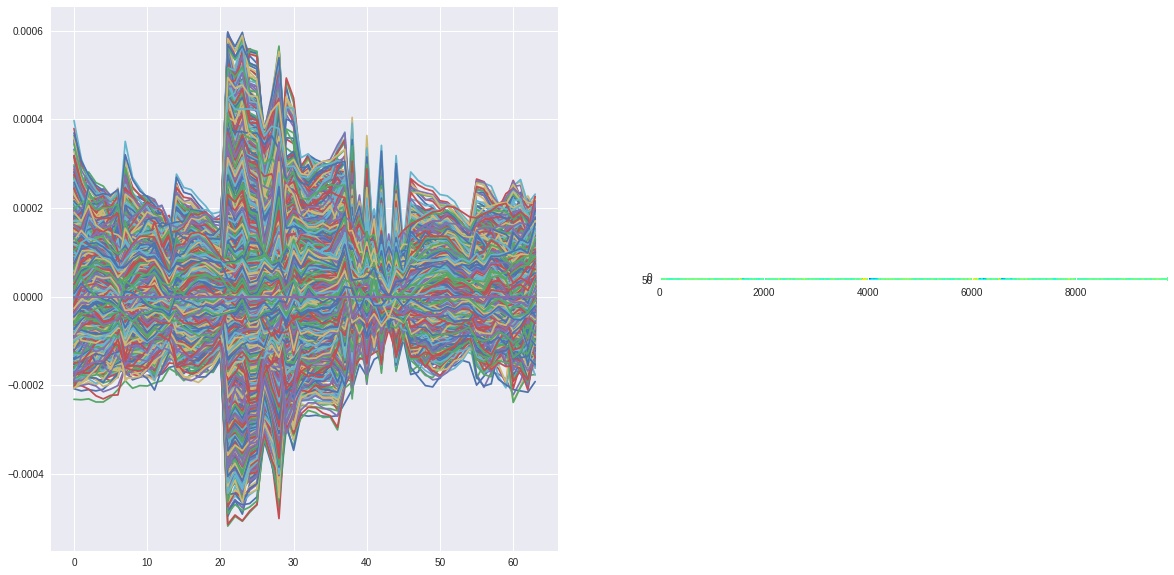

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(xreo)
plt.subplot(122)
plt.jet()
plt.imshow(xreo[:,:])

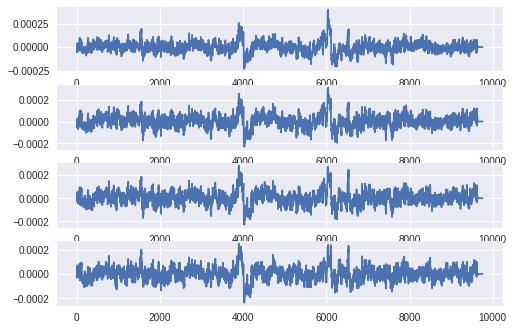

In [ ]:
plt.subplot(411)
plt.plot(xreo[0])
plt.subplot(412)
plt.plot(xreo[1])
plt.subplot(413)
plt.plot(xreo[2])
plt.subplot(414)
plt.plot(xreo[4])

## Machine learning

In [ ]:
%cd files

/content/drive/My Drive/eeg/data/files


### Enumerate movements

Files ending with 01 and 02 are eye movements, 03 contains fist movements (real), 04 contains fist movements (imagined)

In [ ]:
eye_movements = {'01':1,'02':2}
EYE_OPEN = 1
EYE_CLOSED = 2
fist_movements = {'03':3}
imagined_fist_movements = {'04':4}
LEFT_FIST = 3
RIGHT_FIST = 4
THINK_LEFT_FIST = 5
THINK_RIGHT_FIST = 6

### Get all filenames

In [ ]:
import os

# Getting the current work directory (cwd)
thisdir = os.getcwd()
filenames = []
# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if file.endswith(".edf"):
            filenames.append(os.path.join(r, file))

### Eye movements

Get all readings ending in 1 or 2 (eyes open or closed). Crop a short segment 1000-5000 samples.

In [ ]:
X_eye = []
y_eye = []
for file in filenames:
  num = os.path.splitext(os.path.basename(file))[0][5:7]
  if num in eye_movements:
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    X_eye.append(raw_data[:,1000:5000])
    y_eye.append(eye_movements[num])

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R02.edf...
EDF file detected
Setting channel info struct

In [ ]:
# Save
np.save('../data_eye.npy',X_eye)
np.save('../labels_eye.npy',np.array(y_eye))

### Get left fist movements

In [ ]:
X_lfist = []
y_lfist = []
for file in filenames:
  num = os.path.splitext(os.path.basename(file))[0][5:7]
  if num in fist_movements:
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    an = mne.read_annotations(file)
    for i in range(len(an.onset)):
      if an.description[i] == 'T1':
        start_lfist_sec = an.onset[i]
        if an.description[i+1] == 'T0':
          end_lfist_sec = an.onset[i+1]
          X_lfist.append(raw_data[:,int(start_lfist_sec*sampling_rate):int(end_lfist_sec*sampling_rate)])
          y_lfist.append(LEFT_FIST)
          break

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S004/S004R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S005/S005R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S006/S006R03.edf...
EDF file detected
Setting channel info struct

<ipython-input-18-8f4fee81ec78>:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(file)


Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S102/S102R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S103/S103R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S104/S104R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S105/S105R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S106/S106R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/

### Get right fist movements

In [ ]:
X_rfist = []
y_rfist = []
for file in filenames:
  num = os.path.splitext(os.path.basename(file))[0][5:7]
  if num in fist_movements:
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    an = mne.read_annotations(file)
    for i in range(len(an.onset)):
      if an.description[i] == 'T2':
        start_rfist_sec = an.onset[i]
        if an.description[i+1] == 'T0':
          end_rfist_sec = an.onset[i+1]
          X_rfist.append(raw_data[:,int(start_rfist_sec*sampling_rate):int(end_rfist_sec*sampling_rate)])
          y_rfist.append(RIGHT_FIST)
          break

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S004/S004R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S005/S005R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S006/S006R03.edf...
EDF file detected
Setting channel info struct

<ipython-input-57-c84c54d76e71>:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(file)


Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S103/S103R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S104/S104R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S105/S105R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S106/S106R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S107/S107R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S108/S108R03.edf...
EDF file detected
Setting channel info struct

### Merge two fist movements in a single numpy padded array

This is necessary because the readings are uneven in length

In [ ]:
X_pad_fist = np.zeros((218,64,820))

In [ ]:
for i in range(len(X_lfist)):
    for j in range(len(X_lfist[i])):
      for k in range(len(X_lfist[i][j])):
          X_pad_fist[i][j][k] = X_lfist[i][j][k]

In [ ]:
for i in range(len(X_rfist)):
    for j in range(len(X_rfist[i])):
      for k in range(len(X_rfist[i][j])):
          X_pad_fist[i+109][j][k] = X_rfist[i][j][k]

In [ ]:
y_fist = []
for i in range(len(y_lfist)):
  y_fist.append(y_lfist[i])
for i in range(len(y_rfist)):
  y_fist.append(y_rfist[i])
len(y_fist)

218

### Save the data and labels as numpy arrays on drive

In [ ]:
np.save('../data_fist.npy',X_pad_fist)
np.save('../labels_fist.npy',np.array(y_fist))

### Training

Files of fist and eye movements are saved in data directory as numpy arrays

In [ ]:
X = np.load('../data_fist.npy')
y = np.load('../labels_fist.npy')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =1, test_size=0.3)

In [ ]:
X = np.load('../data_eye.npy')
y = np.load('../labels_eye.npy')
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =1, test_size=0.3)

#### SVM

##### For eyes

In [ ]:
X_train_svm = X_train.reshape(len(X_train),64*4000)
X_test_svm = X_test.reshape(len(X_test),64*4000)

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_svm, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test_svm)

In [ ]:
metrics.confusion_matrix(y_pred,y_test)

array([[17,  5],
       [18, 26]])

### SVM with PCA for eyes

In [ ]:
X_train_svm = X_train.reshape(len(X_train),64*4000)
X_test_svm = X_test.reshape(len(X_test),64*4000)

#### 5 component PCA

In [ ]:
pca = RandomizedPCA(n_components=5, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(X_train_svm, y_train)
print(grid.best_params_)

{'svc__C': 50, 'svc__gamma': 0.005}


In [ ]:
pca5_svm_model = grid.best_estimator_
y_pred = pca5_svm_model.predict(X_test_svm)

In [ ]:
metrics.confusion_matrix(y_pred,y_test)

array([[15,  1],
       [20, 30]])

#### 8 component PCA

In [ ]:
pca = RandomizedPCA(n_components=8, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(X_train_svm, y_train)
print(grid.best_params_)

{'svc__C': 50, 'svc__gamma': 0.005}


In [ ]:
pca8_svm_model = grid.best_estimator_
y_pred = pca8_svm_model.predict(X_test_svm)

In [ ]:
metrics.confusion_matrix(y_pred,y_test)

array([[20,  5],
       [15, 26]])

#### 12 component PCA

In [ ]:
pca = RandomizedPCA(n_components=12, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(X_train_svm, y_train)
print(grid.best_params_)

{'svc__C': 50, 'svc__gamma': 0.005}


In [ ]:
pca12_svm_model = grid.best_estimator_

In [ ]:
y_pred = pca12_svm_model.predict(X_test_svm)

In [ ]:
cm = metrics.confusion_matrix(y_pred,y_test)
acc = (cm[0,0] + cm[1,1])/np.sum(cm)
cm, acc

(array([[22,  4],
        [13, 27]]), 0.7424242424242424)

#### 15 component PCA

In [ ]:
pca = RandomizedPCA(n_components=15, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

grid.fit(X_train_svm, y_train)
print(grid.best_params_)

{'svc__C': 50, 'svc__gamma': 0.005}


In [ ]:
pca15_svm_model = grid.best_estimator_

In [ ]:
y_pred = pca15_svm_model.predict(X_test_svm)

In [ ]:
cm = metrics.confusion_matrix(y_pred,y_test)
acc = (cm[0,0] + cm[1,1])/np.sum(cm)
cm, acc

(array([[24,  5],
        [11, 26]]), 0.7575757575757576)

### Plot number of principal components vs accuracy

In [ ]:
accs = []
for i in range(2,20):
  pca = RandomizedPCA(n_components=i, whiten=True, random_state=42)
  svc = SVC(kernel='rbf', class_weight='balanced')
  model = make_pipeline(pca, svc)
  param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
  grid = GridSearchCV(model, param_grid)

  grid.fit(X_train_svm, y_train)
  pca_i_svm_model = grid.best_estimator_
  
  y_pred = pca_i_svm_model.predict(X_test_svm)
  cm = metrics.confusion_matrix(y_pred,y_test)
  acc = (cm[0,0] + cm[1,1])/np.sum(cm)
  accs.append(acc)


NameError: ignored

Text(0, 0.5, 'Accuracy')

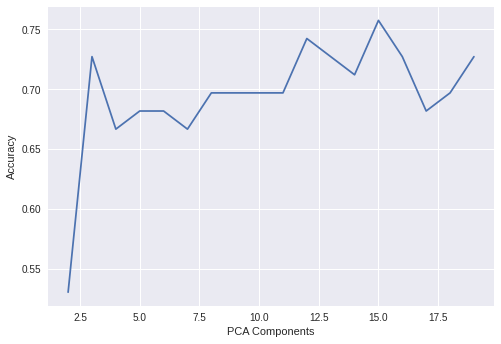

In [ ]:
plt.style.use('seaborn')
plt.plot(range(2,20),accs)
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')

### SVM + PCA for fists

Doesn't work very well for fist movements

In [ ]:
X_train_svm = X_train.reshape(len(X_train),64*820)
X_test_svm = X_test.reshape(len(X_test),64*820)

In [ ]:
X_train.shape

(152, 64, 820)

In [ ]:
pca = RandomizedPCA(n_components=5, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [ ]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
grid.fit(X_train_svm, y_train)
pca_fist_svm_model = grid.best_estimator_

In [ ]:
y_pred = pca_fist_svm_model.predict(X_test_svm)
cm = metrics.confusion_matrix(y_pred,y_test)
acc = (cm[0,0] + cm[1,1])/np.sum(cm)
cm,acc

(array([[22, 27],
        [13,  4]]), 0.3939393939393939)

In [ ]:
accs = []
for i in range(2,20,3):
  pca = RandomizedPCA(n_components=i, whiten=True, random_state=42)
  svc = SVC(kernel='rbf', class_weight='balanced')
  model = make_pipeline(pca, svc)
  param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
  grid = GridSearchCV(model, param_grid)

  grid.fit(X_train_svm, y_train)
  pca_i_svm_model = grid.best_estimator_
  
  y_pred = pca_i_svm_model.predict(X_test_svm)
  cm = metrics.confusion_matrix(y_pred,y_test)
  acc = (cm[0,0] + cm[1,1])/np.sum(cm)
  accs.append(acc)

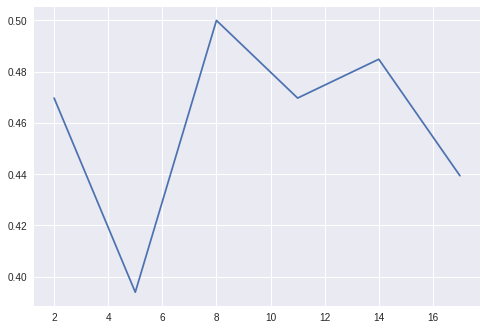

In [ ]:
plt.style.use('seaborn')
plt.plot(range(2,20,3),accs)

### KNN

### For eyes

Trying 3 KNN models gives max 70% accuracy

In [ ]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train_svm, np.ravel(y_train))
print(knn3.score(X_test_svm,np.ravel(y_test)))

knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_svm, np.ravel(y_train))
print(knn5.score(X_test_svm,np.ravel(y_test)))

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_svm, np.ravel(y_train))
print(knn10.score(X_test_svm,np.ravel(y_test)))


### For fists

Trying 3 KNN models gives 63% accuracy

In [ ]:
knn8 = KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train_svm, np.ravel(y_train))
print(knn8.score(X_test_svm,np.ravel(y_test)))

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_svm, np.ravel(y_train))
print(knn10.score(X_test_svm,np.ravel(y_test)))

knn12 = KNeighborsClassifier(n_neighbors=12)
knn12.fit(X_train_svm, np.ravel(y_train))
print(knn12.score(X_test_svm,np.ravel(y_test)))

0.6212121212121212
0.6363636363636364
0.5757575757575758


We now try individual electrode, i.e. no 23 for frontal lobe

In [ ]:
X_22 = X[:,22,:]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_22,y,random_state =1, test_size=0.3)

In [ ]:
X_train_svm = X_train.reshape(len(X_train),820)
X_test_svm = X_test.reshape(len(X_test),820)

In [ ]:
knn8 = KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train_svm, np.ravel(y_train))
print(knn8.score(X_test_svm,np.ravel(y_test)))

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_svm, np.ravel(y_train))
print(knn10.score(X_test_svm,np.ravel(y_test)))

knn12 = KNeighborsClassifier(n_neighbors=12)
knn12.fit(X_train_svm, np.ravel(y_train))
print(knn12.score(X_test_svm,np.ravel(y_test)))

0.48484848484848486
0.48484848484848486
0.45454545454545453


Trying all electrodes one by one

In [ ]:
electrodes = 64
k_values = [5,8,10,12]
scores = np.zeros((64,4))
for i in range(electrodes):
  X_i = X[:,i,:]
  X_train,X_test,y_train,y_test = train_test_split(X_i,y,random_state =1, test_size=0.3)
  X_train_svm = X_train.reshape(len(X_train),820)
  X_test_svm = X_test.reshape(len(X_test),820)

  for j in range(len(k_values)):
    knn_i = KNeighborsClassifier(n_neighbors=k_values[j])
    knn_i.fit(X_train_svm, np.ravel(y_train))
    score = knn_i.score(X_test_svm,np.ravel(y_test))
    scores[i,j] = score

In [ ]:
np.max(scores)

0.7878787878787878

In [ ]:
indices = np.where(scores == scores.max())
indices

(array([38]), array([0]))

In [ ]:
scores[38,0]

0.7878787878787878

Which means the best accuracy was found when k  = k_value[0] = 5 and electrode = 38 (right temporo-pareital)

In [ ]:
x, y = np.meshgrid(range(electrodes), k_values)
z = scores

In [ ]:
X_copy = X
def k_score_for_k_and_electrode(e,k):
  X_i = X_copy[:,e,:]
  X_train,X_test,y_train,y_test = train_test_split(X_i,y,random_state =1, test_size=0.3)
  X_train_svm = X_train.reshape(len(X_train),820)
  X_test_svm = X_test.reshape(len(X_test),820)

  knn_i = KNeighborsClassifier(n_neighbors=k)
  knn_i.fit(X_train_svm, np.ravel(y_train))
  score = knn_i.score(X_test_svm,np.ravel(y_test))
  return score

In [ ]:
k_score_for_k_and_electrode(32,5)

ValueError: ignored

Text(0.5, 0, 'Accuracy')

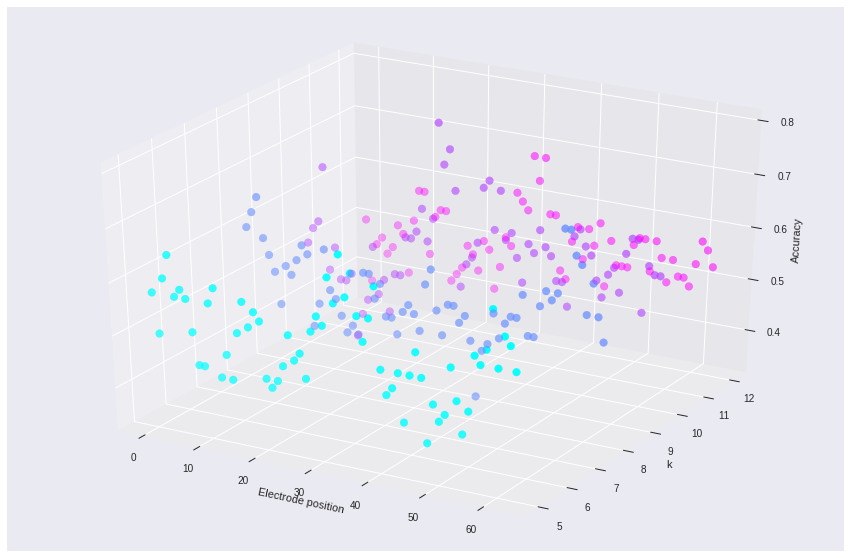

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,cmap='cool',s=60,c=y)
ax.set_xlabel('Electrode position')
ax.set_ylabel('k')
ax.set_zlabel('Accuracy')

### Random forest

#### For eyes

In [ ]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0) 
regressor.fit(X_train_svm, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X_test_svm)

In [ ]:
cm = metrics.confusion_matrix(np.round(y_pred),y_test)
acc = (cm[0,0] + cm[1,1])/np.sum(cm)
cm, acc

array([[24, 10],
       [11, 21]])

#### Fists

In [ ]:
regressor = RandomForestRegressor(n_estimators = 5, random_state = 0) 
regressor.fit(X_train_svm, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = regressor.predict(X_test_svm)

In [ ]:
metrics.confusion_matrix(np.round(y_pred),y_test)
acc = (cm[0,0] + cm[1,1])/np.sum(cm)
cm, acc

(array([[25, 27],
        [10,  4]]), 0.4393939393939394)

## Imagined movements

In [ ]:
X_lfist_img = []
y_lfist_img = []
for file in filenames:
  num = os.path.splitext(os.path.basename(file))[0][5:7]
  if num in imagined_fist_movements:
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    an = mne.read_annotations(file)
    for i in range(len(an.onset)):
     if an.description[i] == 'T1':
       start_lfist_img_sec = an.onset[i]
       if an.description[i+1] == 'T0':
         end_lfist_img_sec = an.onset[i+1]
         X_lfist_img.append(raw_data[:,int(start_lfist_img_sec*sampling_rate):int(end_lfist_img_sec*sampling_rate)])
         y_lfist_img.append(LEFT_FIST)
         break

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S006/S006R04.edf...
EDF file detected
Setting channel info struct

<ipython-input-89-87f08f8c4f44>:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(file)


Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S102/S102R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S103/S103R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S104/S104R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S105/S105R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S106/S106R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/

In [ ]:
X_rfist_img = []
y_rfist_img = []
for file in filenames:
  num = os.path.splitext(os.path.basename(file))[0][5:7]
  if num in imagined_fist_movements:
    data = mne.io.read_raw_edf(file)
    raw_data = data.get_data()
    an = mne.read_annotations(file)
    for i in range(len(an.onset)):
     if an.description[i] == 'T2':
       start_rfist_img_sec = an.onset[i]
       if an.description[i+1] == 'T0':
         end_rfist_img_sec = an.onset[i+1]
         X_rfist_img.append(raw_data[:,int(start_rfist_img_sec*sampling_rate):int(end_rfist_img_sec*sampling_rate)])
         y_rfist_img.append(RIGHT_FIST)
         break

Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S006/S006R04.edf...
EDF file detected
Setting channel info struct

<ipython-input-93-ab41757167b1>:6: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_edf(file)


Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S103/S103R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S104/S104R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S105/S105R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S106/S106R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S107/S107R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/My Drive/eeg/data/files/S108/S108R04.edf...
EDF file detected
Setting channel info struct

In [ ]:
X_pad_fist_img = np.zeros((218,64,820))

In [ ]:
for i in range(len(X_lfist_img)):
    for j in range(len(X_lfist_img[i])):
      for k in range(len(X_lfist_img[i][j])):
          X_pad_fist_img[i][j][k] = X_lfist_img[i][j][k]

In [ ]:
for i in range(len(X_rfist_img)):
    for j in range(len(X_rfist_img[i])):
      for k in range(len(X_rfist_img[i][j])):
          X_pad_fist_img[i+109][j][k] = X_rfist_img[i][j][k]

In [ ]:
y_fist_img = []
for i in range(len(y_lfist_img)):
  y_fist_img.append(y_lfist_img[i])
for i in range(len(y_rfist_img)):
  y_fist_img.append(y_rfist_img[i])
len(y_fist_img)

218

In [ ]:
np.save('../data_fist_img.npy',X_pad_fist_img)
np.save('../labels_fist_img.npy',np.array(y_fist_img))

In [ ]:
X = np.load('../data_fist_img.npy')
y = np.load('../labels_fist_img.npy')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state =1, test_size=0.3)

In [ ]:
X_train_svm = X_train.reshape(len(X_train),64*820)
X_test_svm = X_test.reshape(len(X_test),64*820)

In [ ]:
knn8 = KNeighborsClassifier(n_neighbors=8)
knn8.fit(X_train_svm, np.ravel(y_train))
print(knn8.score(X_test_svm,np.ravel(y_test)))

knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_svm, np.ravel(y_train))
print(knn10.score(X_test_svm,np.ravel(y_test)))

knn12 = KNeighborsClassifier(n_neighbors=12)
knn12.fit(X_train_svm, np.ravel(y_train))
print(knn12.score(X_test_svm,np.ravel(y_test)))

0.5303030303030303
0.6060606060606061
0.5757575757575758


In [ ]:
electrodes = 64
k_values = [5,8,10,12]
scores = np.zeros((64,4))
for i in range(electrodes):
  X_i = X[:,i,:]
  X_train,X_test,y_train,y_test = train_test_split(X_i,y,random_state =1, test_size=0.3)
  X_train_svm = X_train.reshape(len(X_train),820)
  X_test_svm = X_test.reshape(len(X_test),820)

  for j in range(len(k_values)):
    knn_i = KNeighborsClassifier(n_neighbors=k_values[j])
    knn_i.fit(X_train_svm, np.ravel(y_train))
    score = knn_i.score(X_test_svm,np.ravel(y_test))
    scores[i,j] = score

In [ ]:
np.max(scores)

0.6818181818181818

In [ ]:
indices = np.where(scores == scores.max())
indices

(array([30]), array([3]))

Best accuracy in predicting imagined movements (68%) was found in lead 31 (left frontal)

In [ ]:
x, y = np.meshgrid(range(electrodes), k_values)
z = scores

Text(0.5, 0, 'Accuracy')

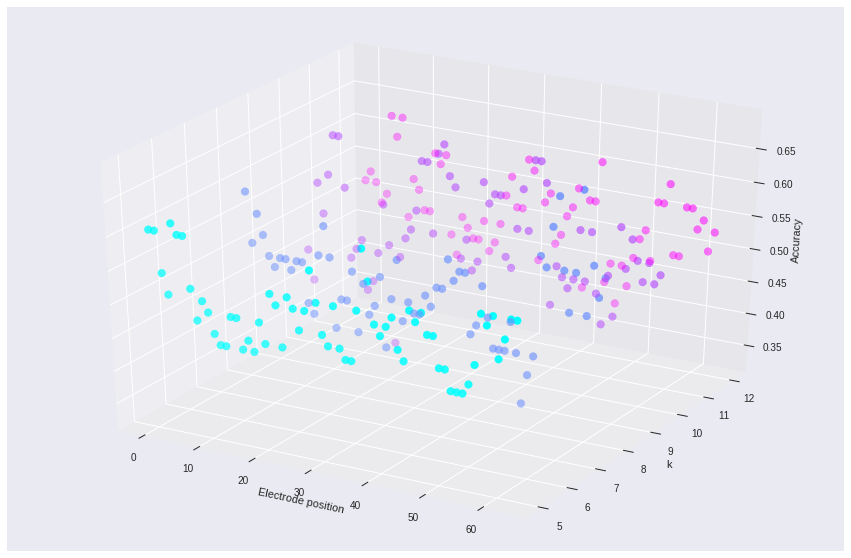

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,cmap='cool',s=60,c=y)
ax.set_xlabel('Electrode position')
ax.set_ylabel('k')
ax.set_zlabel('Accuracy')